In [1]:
import torch
import segmentation_models_pytorch as smp
import monai

from data_organization import HIE_Dataset, reassemble_to_3d
from pipeline_utils import *
from transforms.preprocess_v2 import transform_2d, padding

import pandas as pd
import numpy as np

/Users/amograo/Research_Projects/DL_HIE_2024/env_hie/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
channels = 1
# model_path = "/Users/amograo/Desktop/HIE-BONBID-24/2D_densenet161-DiceFocal-Stacked/models/model_epoch_45_densenet161.pth"
model_path = "/Users/amograo/Desktop/HIE-BONBID-24/2D_efficientnet-b5-DiceFocal/models/model_epoch_124_efficientnet-b5.pth"
ENCODER = "efficientnet-b5"

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print(DEVICE)
# ENCODER = "se_resnext101_32x4d"
DATA_ROOT = "/Users/amograo/Desktop/DATASET"

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=None,     
    in_channels=channels,             
    classes=1,
    activation='sigmoid'               
)

model.to(DEVICE)

# checkpoint = torch.load("/Users/amograo/Desktop/HIE-BONBID-24/2D_densenet161-DiceFocal-Stacked/models/model_epoch_57_densenet161.pth",map_location=torch.device(DEVICE))  
checkpoint = torch.load(model_path,map_location=torch.device(DEVICE))      
model.load_state_dict(checkpoint['model_state_dict'])


df = pd.read_csv(f'{DATA_ROOT}/BONBID2024_Val/metadata.csv')
uids = [str(i).zfill(3) for i in df["Patient ID"].tolist()]
print(uids)

preds_3d = {i: [] for i in uids}
masks_3d = {uid: reassemble_to_3d(f'{DATA_ROOT}/BONBID2024_Val/LABEL', uid) for uid in uids}


mps


/var/folders/sb/tjd4rgj975q74d1l278__rb40000gn/T/ipykernel_2031/560322119.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path,map_locatio

['436', '302', '001', '002']


In [4]:
# def show_masks_side_by_side(gt_masks, pred_masks):
#     """
#     Display GT Mask and Predicted Mask side by side for all slices.

#     Parameters:
#     gt_masks (numpy array): Ground truth masks with shape (num_slices, height, width)
#     pred_masks (numpy array): Predicted masks with shape (num_slices, height, width)
#     """
#     num_slices = gt_masks.shape[0]
    
#     for i in range(num_slices):
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
#         axes[0].imshow(gt_masks[i], cmap='gray')
#         axes[0].set_title(f'GT Mask - Slice {i}')
#         axes[0].axis('off')
        
#         axes[1].imshow(pred_masks[i], cmap='gray')
#         axes[1].set_title(f'Predicted Mask - Slice {i}')
#         axes[1].axis('off')
        
#         plt.show()

import matplotlib.pyplot as plt

def show_all_slices_in_grid(gt_masks, pred_masks, pairs_per_row=4):
    """
    Display all GT Mask and Predicted Mask slices in a grid with specified pairs per row.

    Parameters:
    gt_masks (numpy array): Ground truth masks with shape (num_slices, height, width)
    pred_masks (numpy array): Predicted masks with shape (num_slices, height, width)
    pairs_per_row (int): Number of image pairs per row
    """
    num_slices = gt_masks.shape[0]
    rows = (num_slices + pairs_per_row - 1) // pairs_per_row  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(20, rows * 5))
    
    for i in range(num_slices):
        row = i // pairs_per_row
        col = (i % pairs_per_row) * 2
        
        axes[row, col].imshow(gt_masks[i], cmap='gray')
        axes[row, col].set_title(f'GT Mask - Slice {i}')
        axes[row, col].axis('off')
        
        axes[row, col + 1].imshow(pred_masks[i], cmap='gray')
        axes[row, col + 1].set_title(f'Predicted Mask - Slice {i}')
        axes[row, col + 1].axis('off')
    
    # Hide any unused subplots
    for j in range(num_slices, rows * pairs_per_row):
        row = j // pairs_per_row
        col = (j % pairs_per_row) * 2
        axes[row, col].axis('off')
        axes[row, col + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
# gt_masks and pred_masks should be numpy arrays with shape (num_slices, height, width)
# show_all_slices_in_grid(gt_masks, pred_masks)

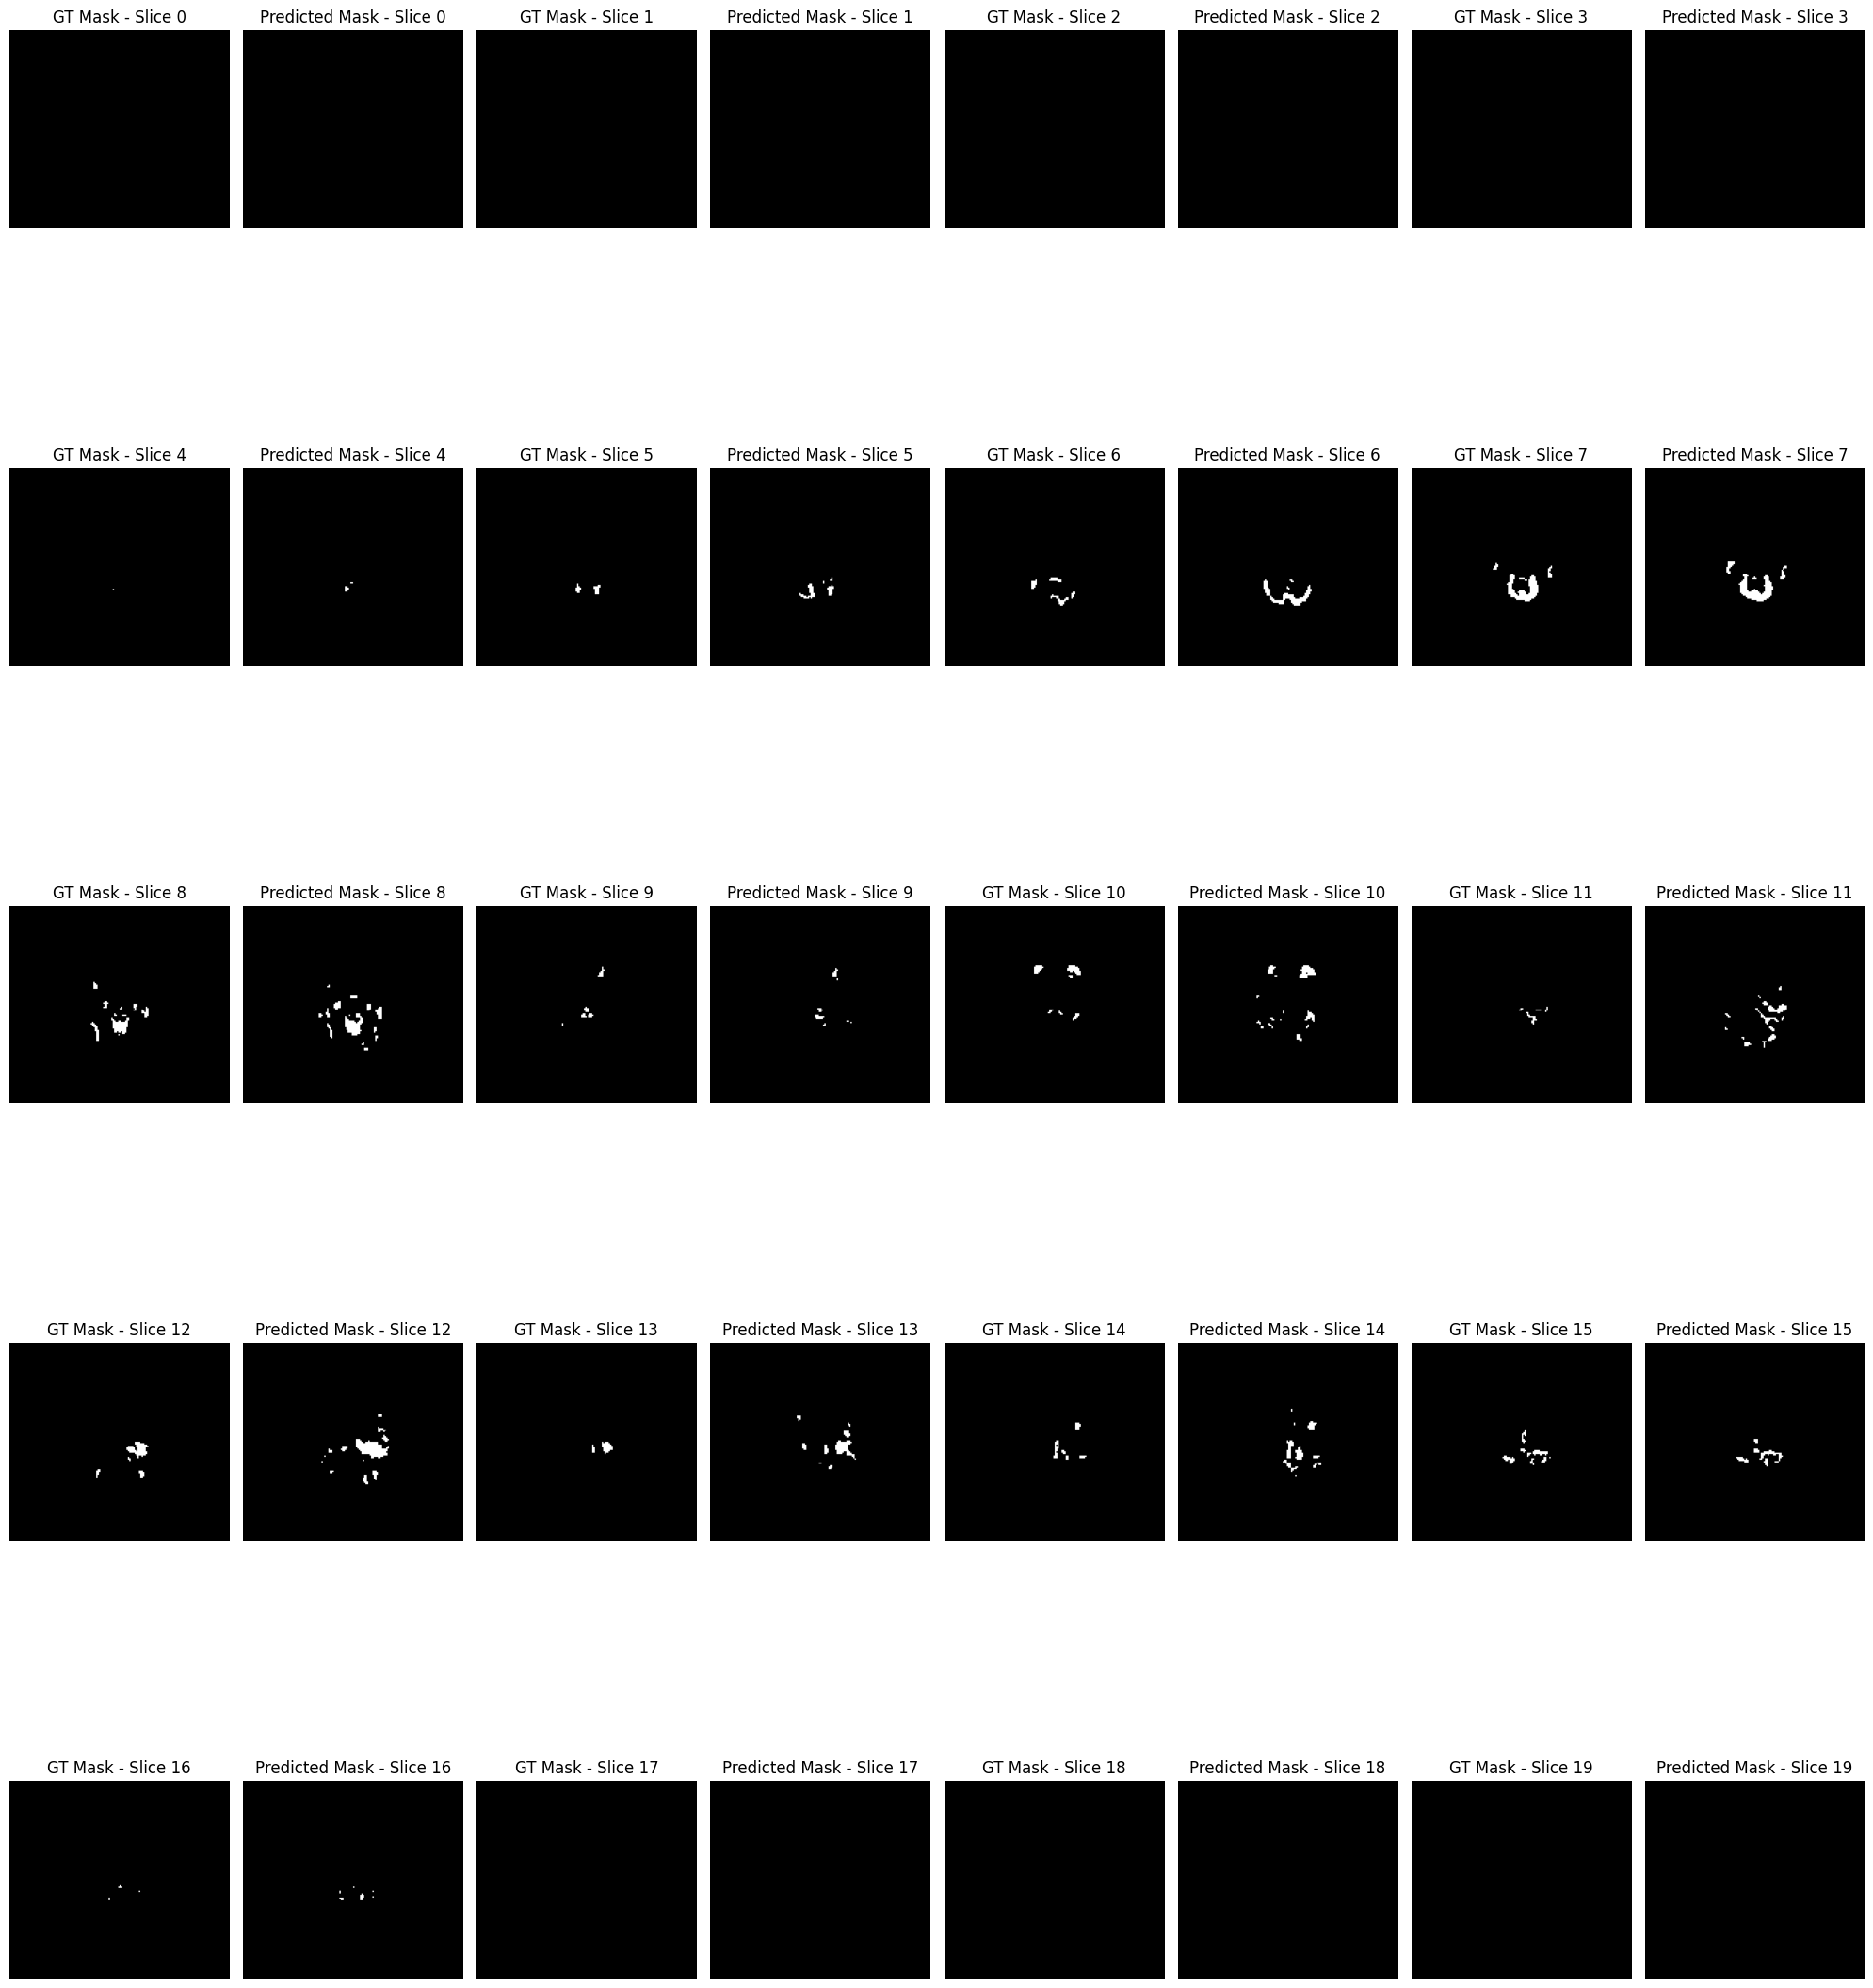

436
Dice: 0.6149837374687195
MASD: 0.9462206363677979
NSD: 0.8391376733779907


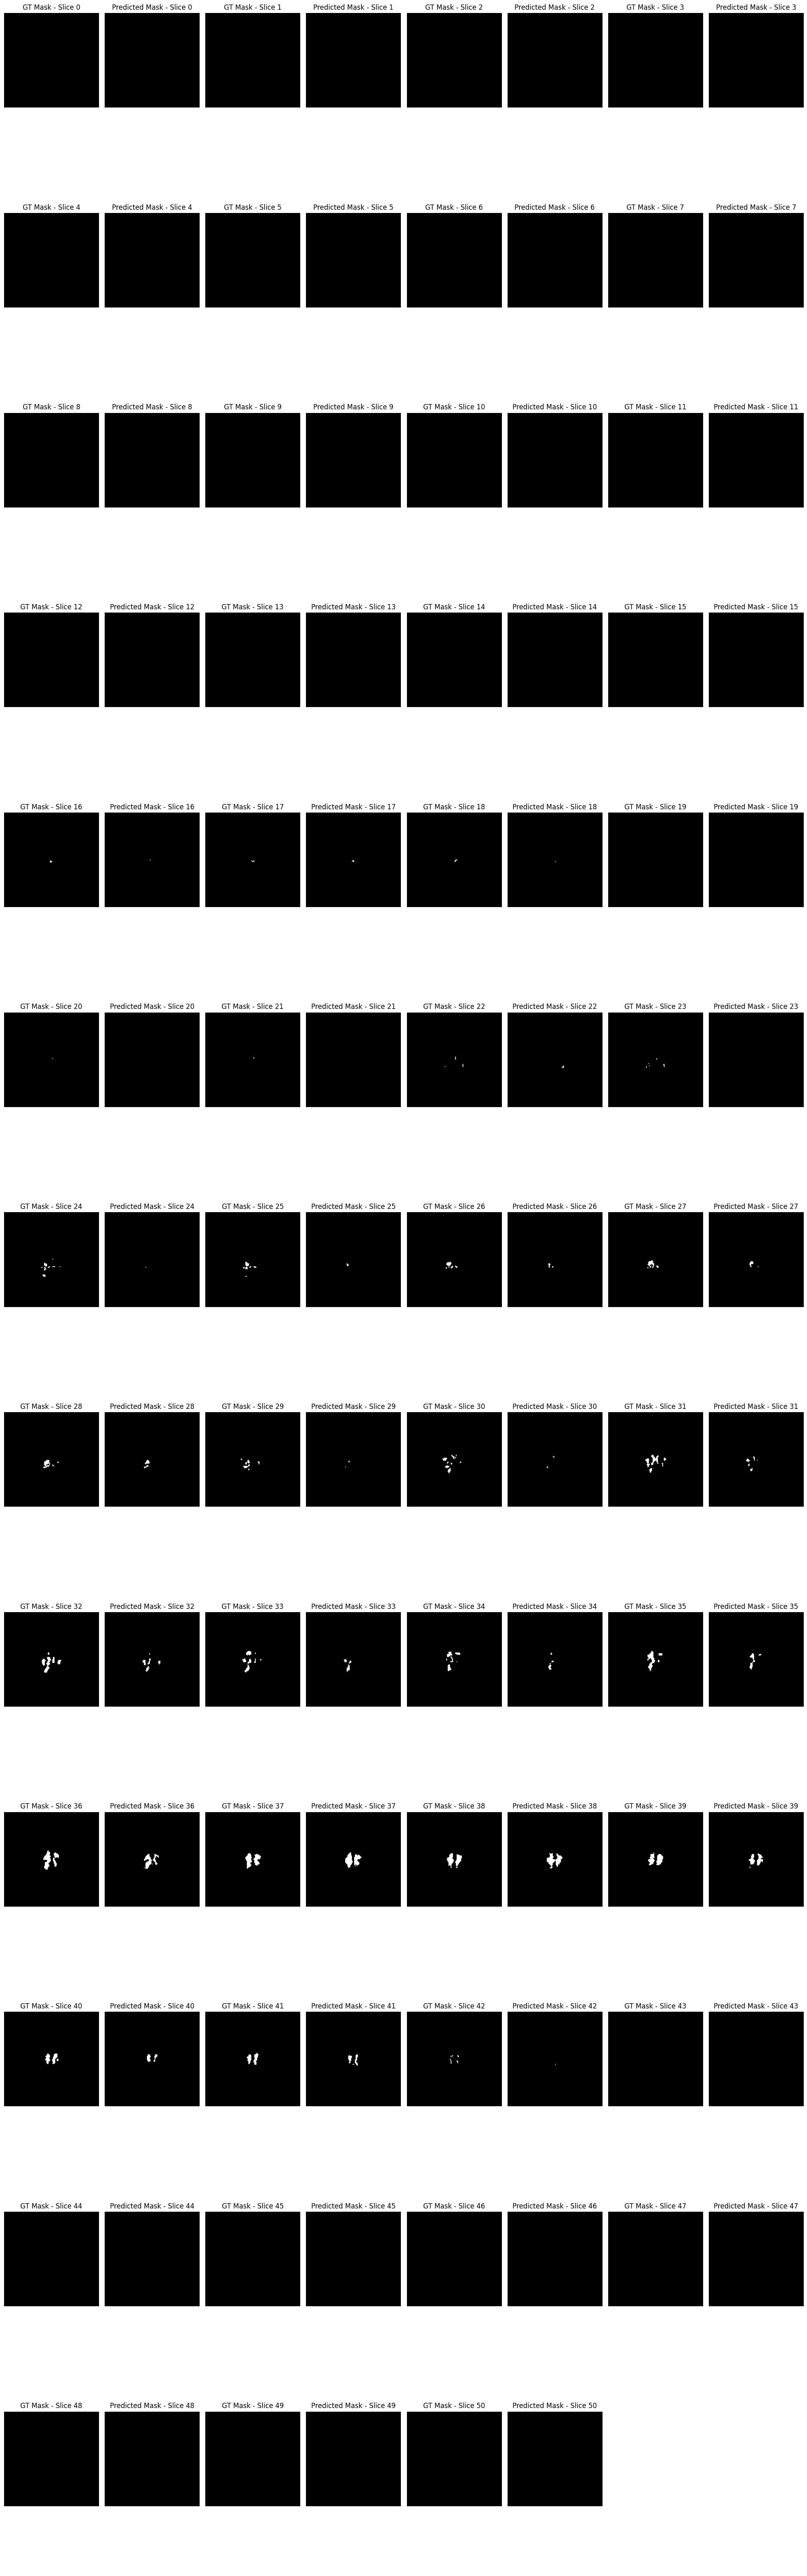

302
Dice: 0.6466784477233887
MASD: 0.8497266173362732
NSD: 0.9210419058799744


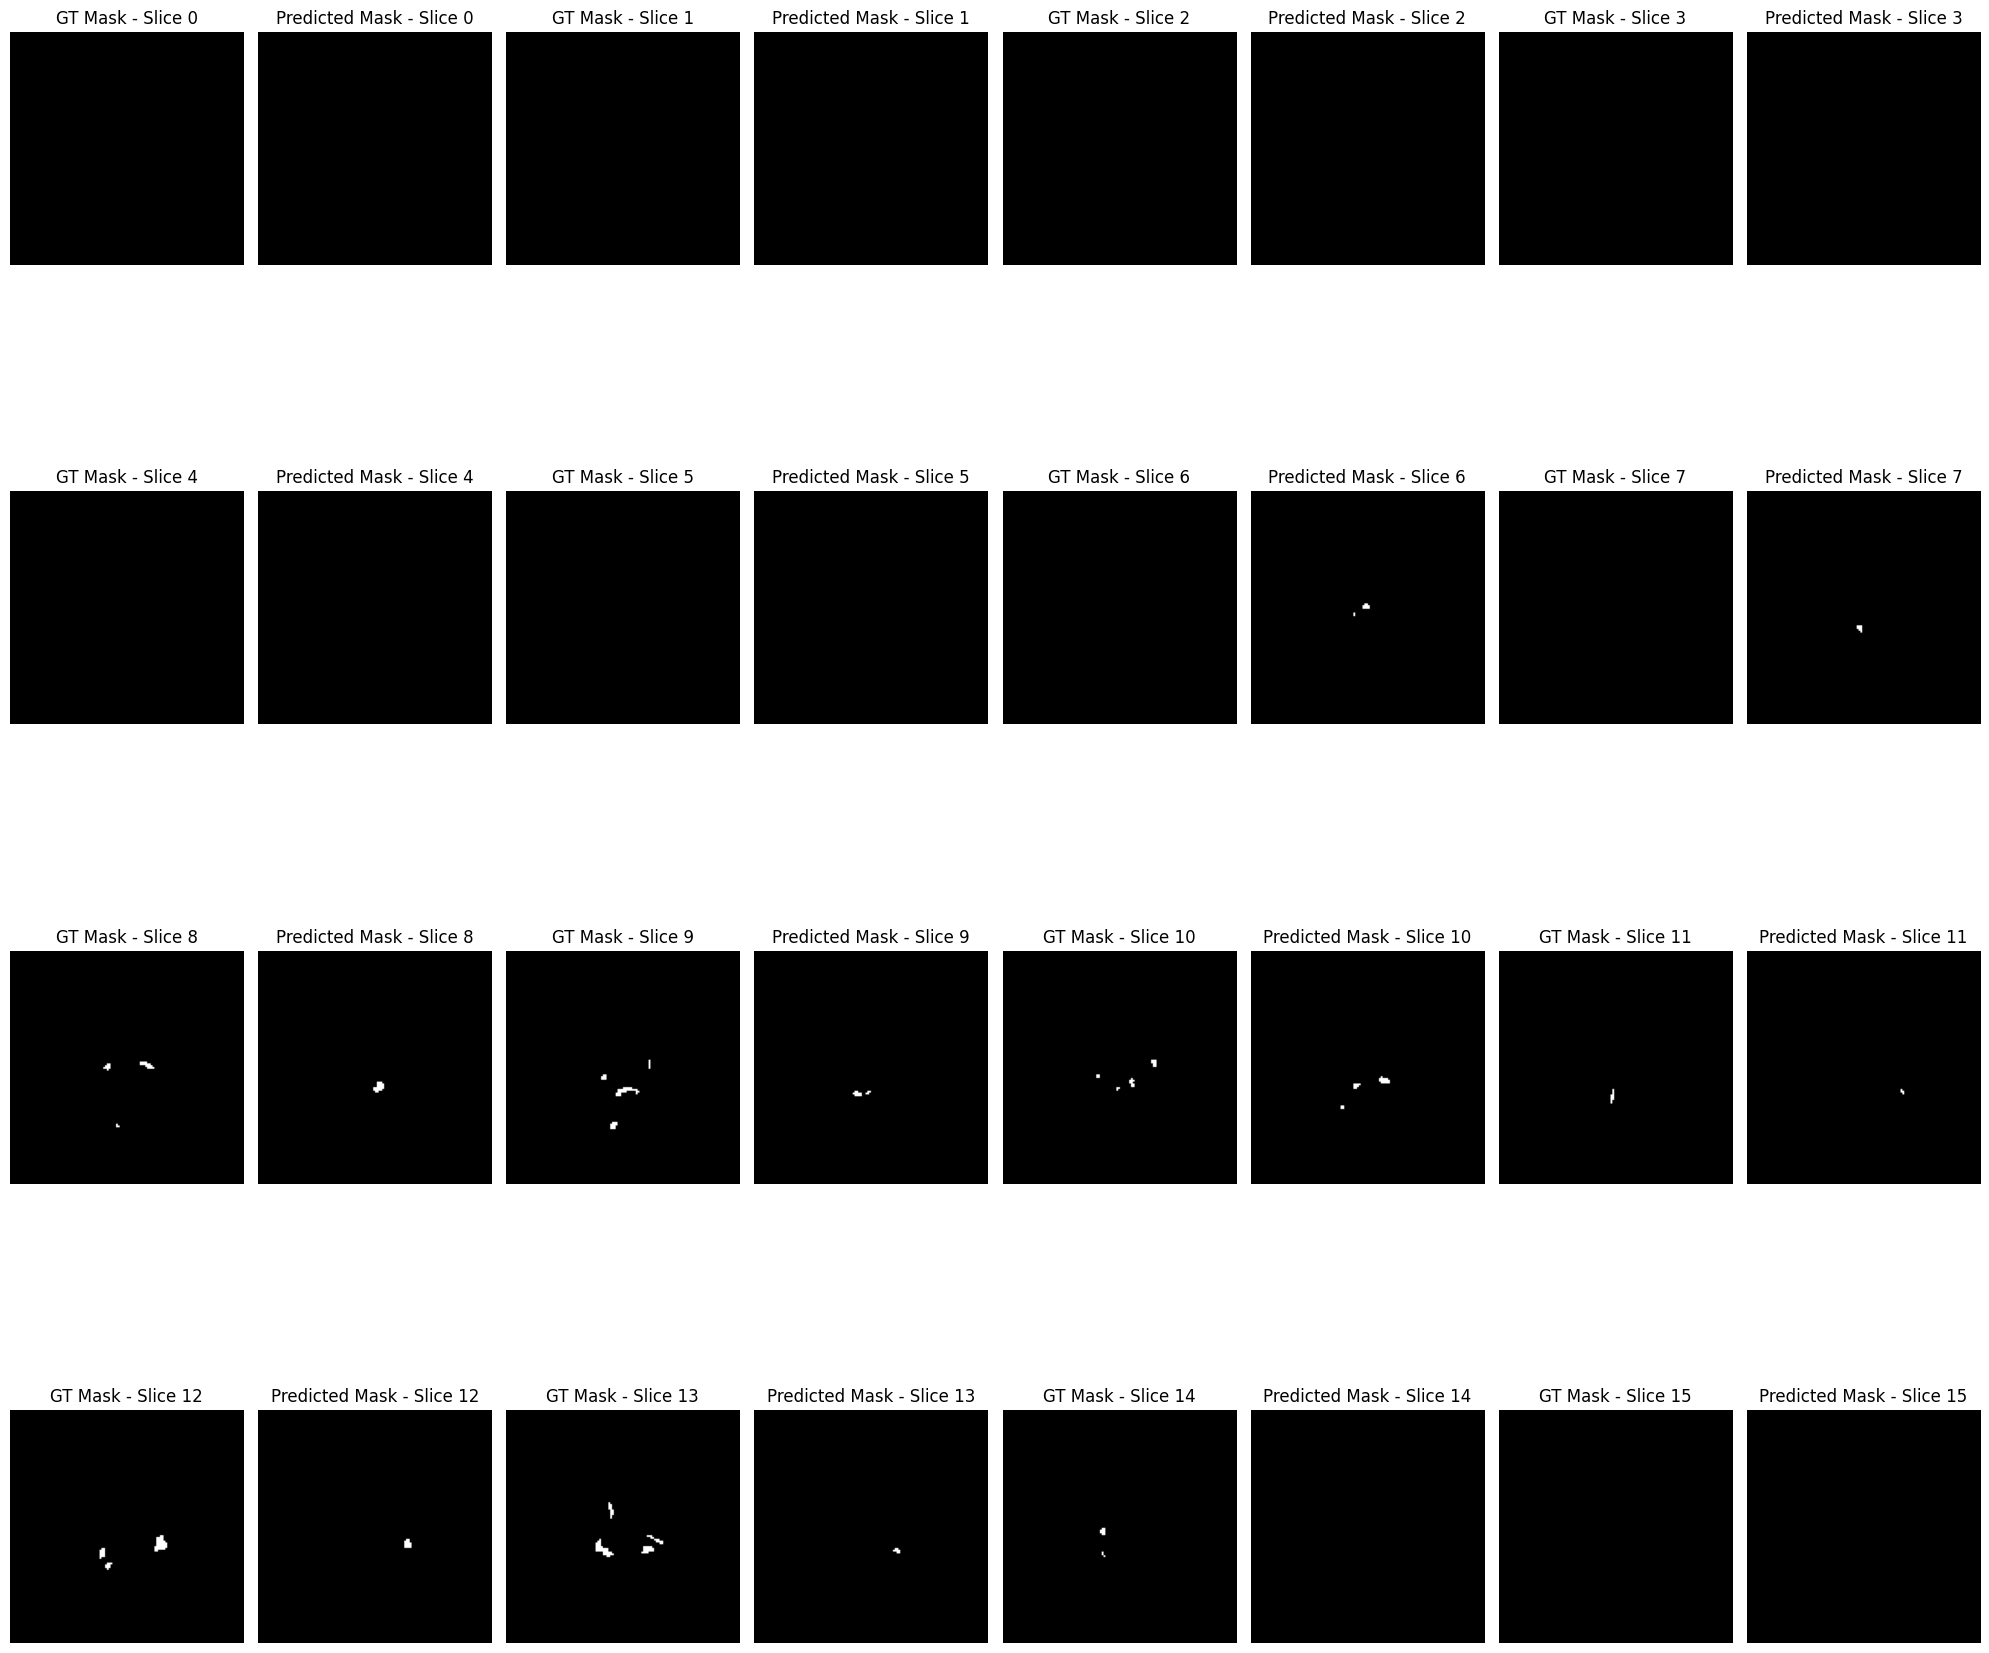

001
Dice: 0.14492753148078918
MASD: 3.9177682399749756
NSD: 0.4106280207633972


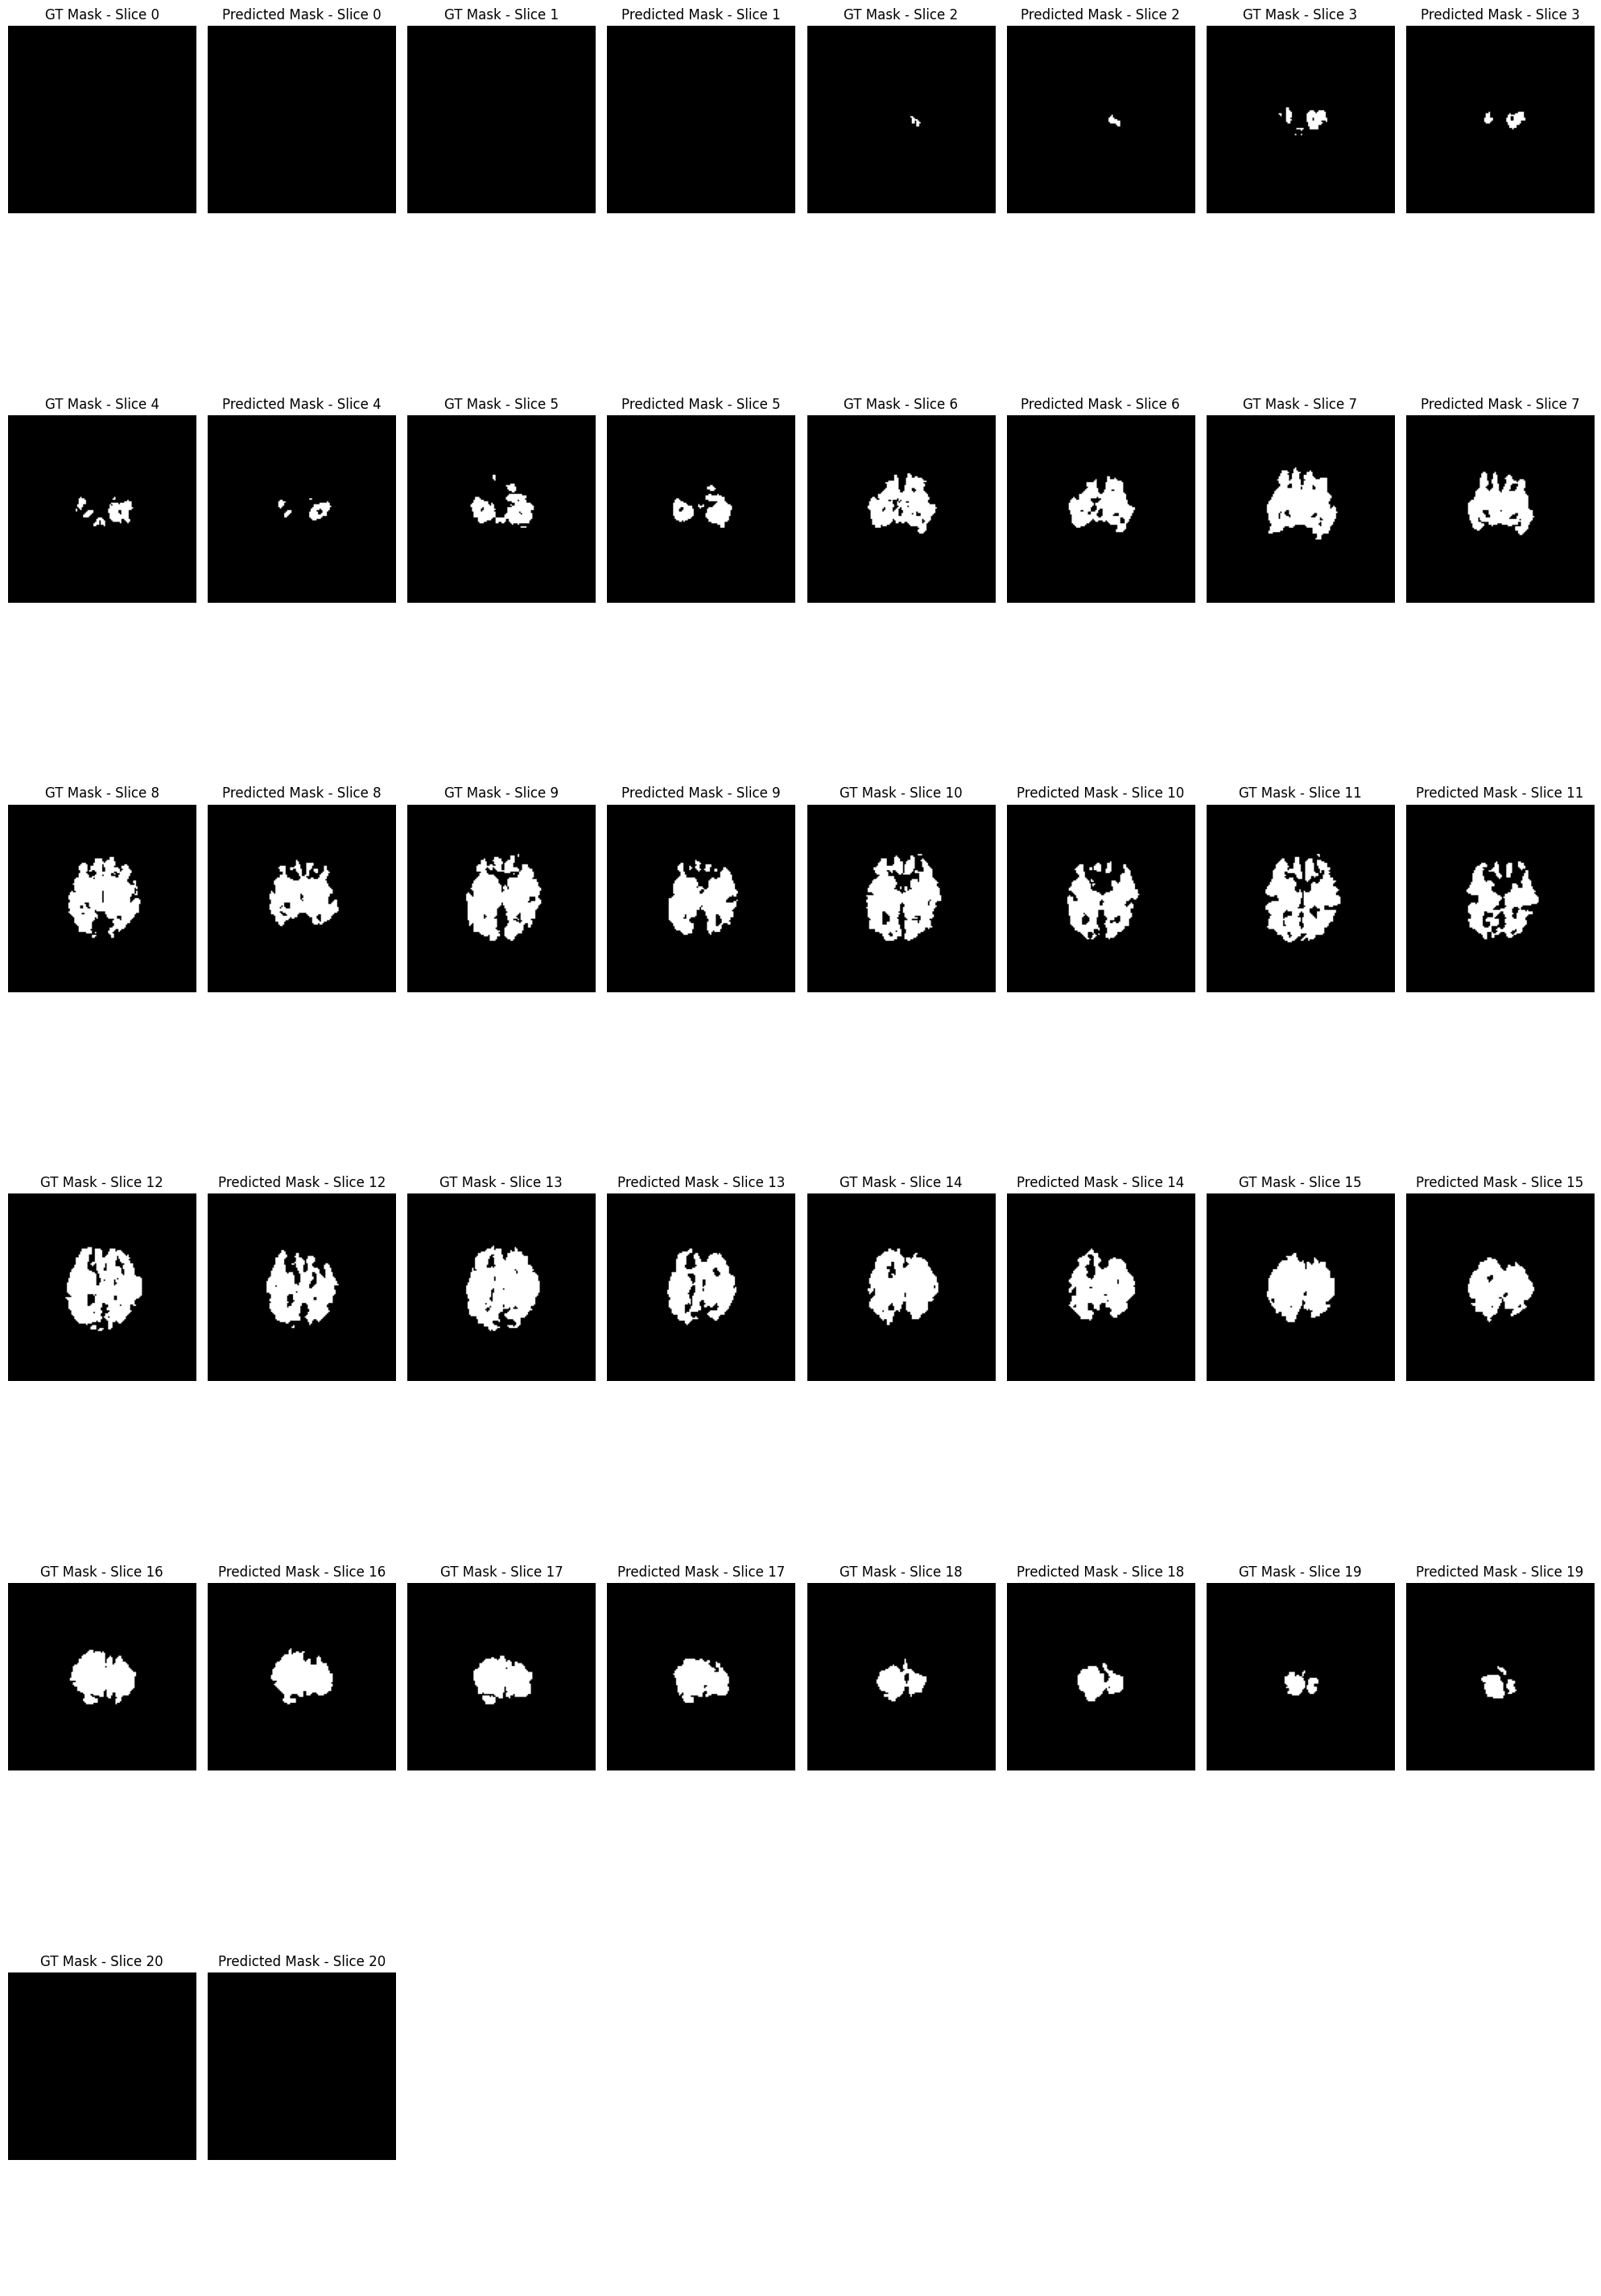

002
Dice: 0.8711269497871399
MASD: 0.563569962978363
NSD: 0.9817208051681519


In [5]:

dice_l = []
masd_l = []
nsd_l = []
image_paths = [f'{DATA_ROOT}/BONBID2024_Val/Z_ADC'] if channels==1 else  [f'{DATA_ROOT}/BONBID2024_Val/ADC', f'{DATA_ROOT}/BONBID2024_Val/Z_ADC']
for uid in uids:
    image_set = [reassemble_to_3d(path, uid) for path in image_paths]
    # image_set = reassemble_to_3d(f'{DATA_ROOT}/BONBID2024_Val/Z_ADC', uid)

    for i in range(image_set[0].shape[0]):
        image = np.expand_dims(transform_2d(np.stack([image_set[j][i] for j in range(len(image_set))]),['Z_ADC'] if channels==1 else ['ADC','Z_ADC']),axis=0)
        # image = np.expand_dims(resample(np.stack([image_set[i]])),axis=0)

        image = torch.tensor(image).to(DEVICE)

        output = model(image)
        pred = (output >= 0.5).float()

        # print(image_set[0].shape)
        # print(list(image_set[0].shape))
        shape = image_set[0].shape
        shape = (1,shape[1],shape[2])
        # print(shape)

        preds_3d[uid].append(padding(pred.cpu().detach().numpy()[0],target_size=tuple(shape))[0])    


        # print(pred.shape)
        # print(np.array(preds_3d[uid]).shape)
        if len(preds_3d[uid]) == image_set[0].shape[0]:
            preds_3d[uid] = np.stack(preds_3d[uid])
            dice = monai.metrics.DiceMetric(include_background=True,ignore_empty=False)
            masd = monai.metrics.SurfaceDistanceMetric(include_background=False, symmetric = True)
            nsd = monai.metrics.SurfaceDiceMetric(include_background=False, distance_metric="euclidean", class_thresholds=[2])
            show_all_slices_in_grid(masks_3d[uid],preds_3d[uid])
            preds_mask = torch.tensor(preds_3d[uid]).unsqueeze(0).unsqueeze(0)
            true_mask = torch.tensor(masks_3d[uid]).unsqueeze(0).unsqueeze(0)
            print(uid)
            dice_val = dice(preds_mask,true_mask).item()
            masd_val = masd(preds_mask,true_mask).item()
            nsd_val = nsd(preds_mask,true_mask).item()
            dice_l.append(dice_val)
            masd_l.append(masd_val)
            nsd_l.append(nsd_val)
            print("Dice:",dice_val)
            print("MASD:",masd_val)
            print("NSD:",nsd_val)

In [6]:
print()
print("Average Metrics")
print("Dice",np.mean(dice_l))
print("MASD",np.mean(masd_l))
print("NSD",np.mean(nsd_l))


Average Metrics
Dice 0.5694291666150093
MASD 1.5693213641643524
NSD 0.7881321012973785
